# Graph atom/bond uncertainties

Display images along with predicted molecules and show model probabilities of uncertain atoms/bonds.

The nice drawings are in the last code block.

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [167]:
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from bms.dataset import generate_indigo_image
from bms.tokenizer import NodeTokenizer
from bms.chemistry import convert_smiles_to_inchi, _postprocess_smiles
from bms.evaluate import canonicalize_smiles
from SmilesPE.pretokenizer import atomwise_tokenizer

from indigo import Indigo
from indigo.renderer import IndigoRenderer
import rdkit.Chem as Chem

from bms.augment import CropWhite
import albumentations as A

gold_root = '../data/molbank/'
pred_root = '../output/'

df_paths = [#'uspto_test/uspto_chemdraw.csv',
            #'Img2Mol/CLEF.csv',
            #'Img2Mol/JPO.csv',
            'Img2Mol/UOB.csv',
            #'Img2Mol/USPTO.csv',
            #'Img2Mol/staker.csv', 
            # 'real-acs-evaluation/acs.csv'
            'acs/acs-331.csv'
           ]
extra_img_paths = [#'../data/molbank/', 
                   '../', '../', '../', '../', '../', '../']
nodes_pred_df_paths = [#'pubchem/synthetic/swin_base_aux_200k_char_aug_b256/prediction_uspto_chemdraw.csv',
                       #'uspto/swin_base_aux_200k_char_aug_b256/prediction_CLEF.csv',
                       #'uspto/swin_base_aux_200k_char_aug_b256/prediction_JPO.csv',
                       'uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv',
                       #'uspto/swin_base_aux_200k_char_aug_b256/prediction_USPTO.csv',
                       #'uspto/swin_base_aux_200k_char_aug_b256/prediction_staker.csv',
                       'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv'
                      ]

tokenizer = NodeTokenizer(50)

NON_ATOM_SYMB = '0123456789().-=#$:/\\%'

DATA: Img2Mol/UOB.csv
PRED: uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv
## 116 ##
Image ID: maybridge-0119-504065841
Gold: CC(C)(C)S(=O)(=O)c1c[nH]c(=N)[nH]c1=N
Pred: CC(S(O)(C1C(N)=NC(N)=NC=1)=O)(C)C
Post: CC(C)(C)[SH](=O)(O)c1cnc(N)nc1N
Indices: [3, 6, 10, 14, 19, 23, 27, 32, 35, 39, 44, 47, 54, 59, 63]
[3, 6, 10, 14, 19, 23, 27, 32, 35, 39, 44, 47, 54, 59, 63]
['C', 'C', '(', 'S', '(', 'O', ')', '(', 'C', '1', 'C', '(', 'N', ')', '=', 'N', 'C', '(', 'N', ')', '=', 'N', 'C', '=', '1', ')', '=', 'O', ')', '(', 'C', ')', 'C']
(389, 777, 3)


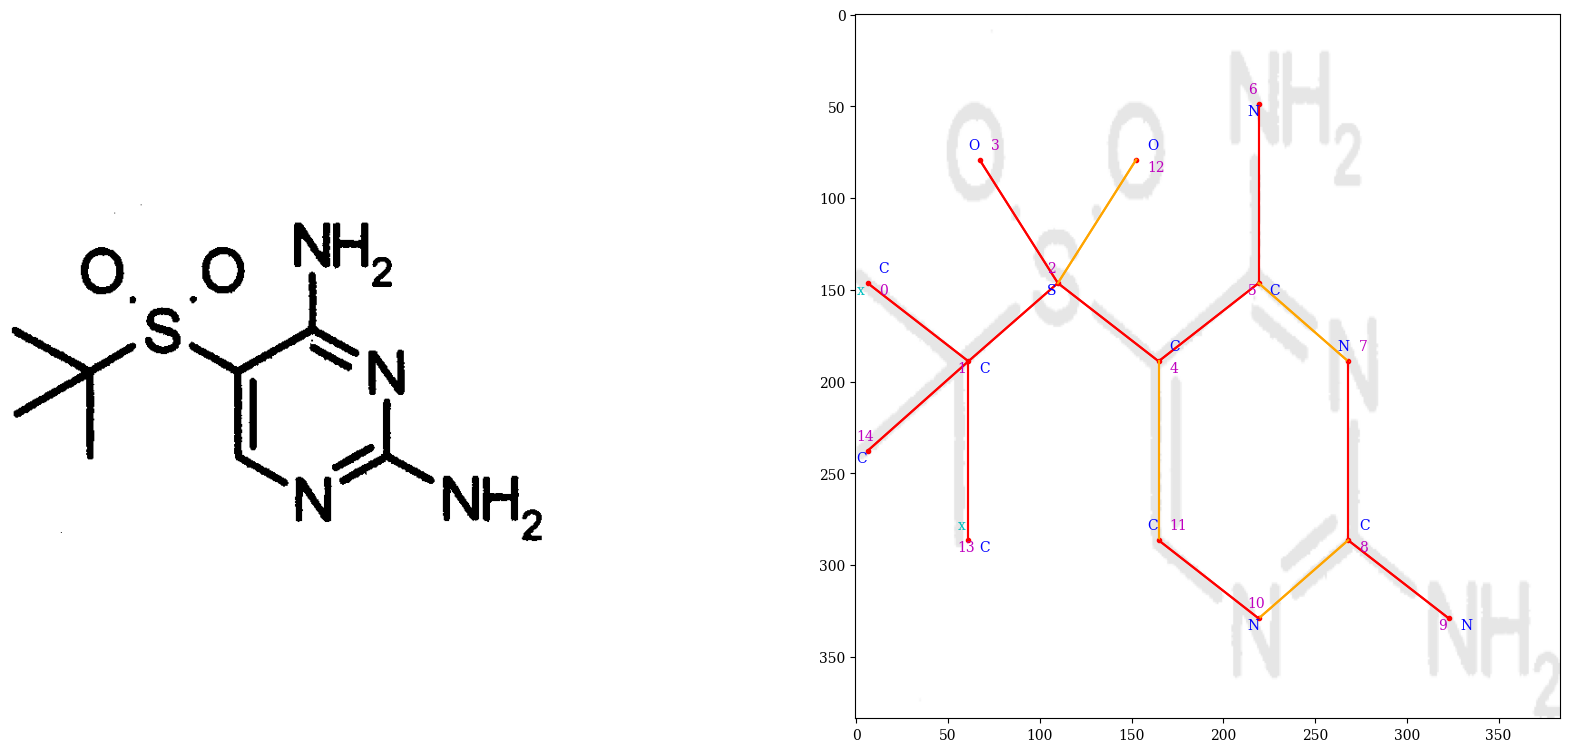

## 407 ##
Image ID: maybridge-0086-895740908
Gold: [CH3:0][C:0]([CH3:0])([CH3:0])[NH:0][C:0](=[O:0])[C@@H:0]1[CH2:0][C@@H:0]2[CH2:0][CH2:0][CH2:0][CH2:0][C@@H:0]2[CH2:0][NH:0]1
Pred: CC(NC([C@H]1NC[C@]2([H])C([H])(CCCC2)C1)=O)(C)C
Post: [H]C12CCCC[C@]1([H])CN[C@H](C(=O)NC(C)(C)C)C2
Indices: [3, 6, 10, 13, 21, 25, 28, 34, 41, 45, 51, 56, 59, 62, 65, 70, 76, 81, 85]
[3, 6, 10, 13, 21, 25, 28, 34, 41, 45, 51, 56, 59, 62, 65, 70, 76, 81, 85]
['C', 'C', '(', 'N', 'C', '(', '[C@H]', '1', 'N', 'C', '[C@]', '2', '(', '[H]', ')', 'C', '(', '[H]', ')', '(', 'C', 'C', 'C', 'C', '2', ')', 'C', '1', ')', '=', 'O', ')', '(', 'C', ')', 'C']
(611, 833, 3)


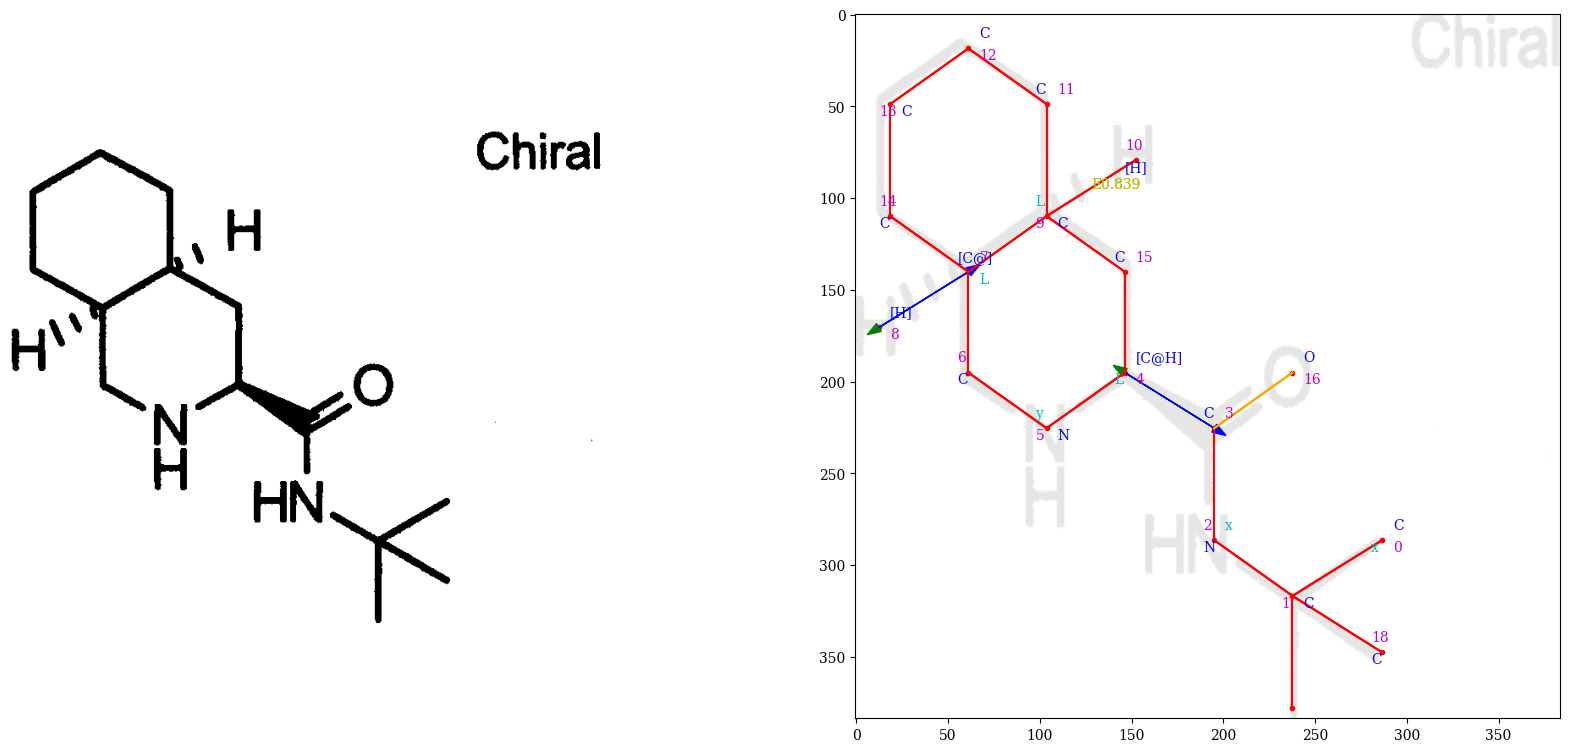

DATA: acs/acs-331.csv
PRED: uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv
## 210 ##
Image ID: acs.orglett.5b02743-Scheme-c2-15
Gold: CC(C)(C)S(=O)Nc1ccccc1
Pred: CC([S@@](NC1C=CC=CC=1)=O)(C)C
Post: CC(C)(C)[S@](O)Nc1ccccc1
Indices: [3, 6, 14, 18, 21, 25, 29, 32, 36, 39, 46, 51, 55]
[3, 6, 14, 18, 21, 25, 29, 32, 36, 39, 46, 51, 55]
['C', 'C', '(', '[S@@]', '(', 'N', 'C', '1', 'C', '=', 'C', 'C', '=', 'C', 'C', '=', '1', ')', '=', 'O', ')', '(', 'C', ')', 'C']
(192, 321, 3)


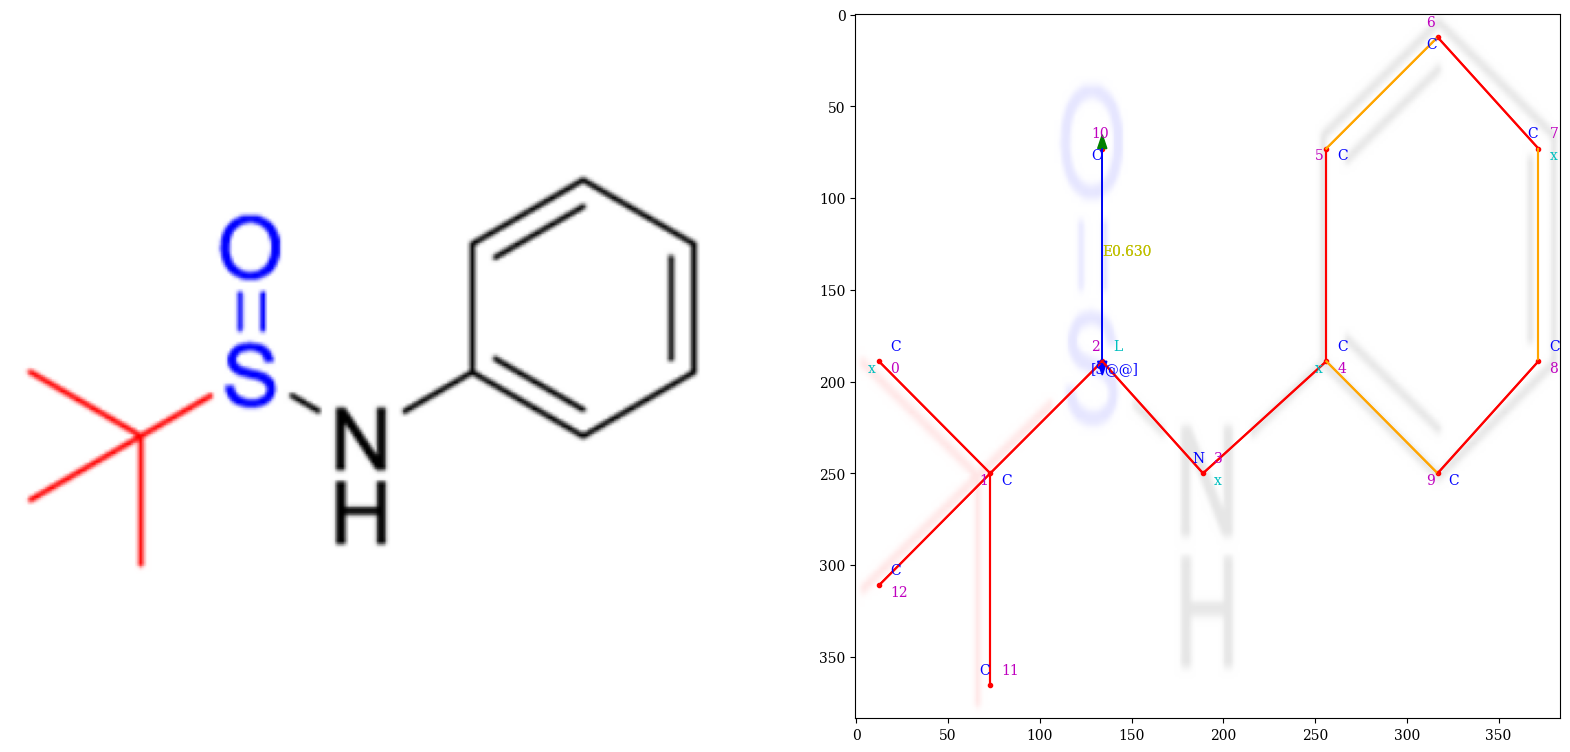

## 256 ##
Image ID: op050182n-Figure-c1-0
Gold: Cc1ccc(S(=O)(=O)N2[C@@H]3c4ccccc4C[C@@H]3O[S]2O)cc1
Pred: N1([Ts])[C@H]2C3C=CC=CC=3C[C@H]2O[S@@H]1O
Post: Cc1ccc(S(=O)(=O)N2[C@@H]3c4ccccc4C[C@@H]3O[SH]2O)cc1
Indices: [3, 11, 19, 23, 27, 31, 34, 38, 41, 46, 53, 57, 65, 69]
[3, 11, 19, 23, 27, 31, 34, 38, 41, 46, 53, 57, 65, 69]
['N', '1', '(', '[Ts]', ')', '[C@H]', '2', 'C', '3', 'C', '=', 'C', 'C', '=', 'C', 'C', '=', '3', 'C', '[C@H]', '2', 'O', '[S@@H]', '1', 'O']
(211, 313, 3)


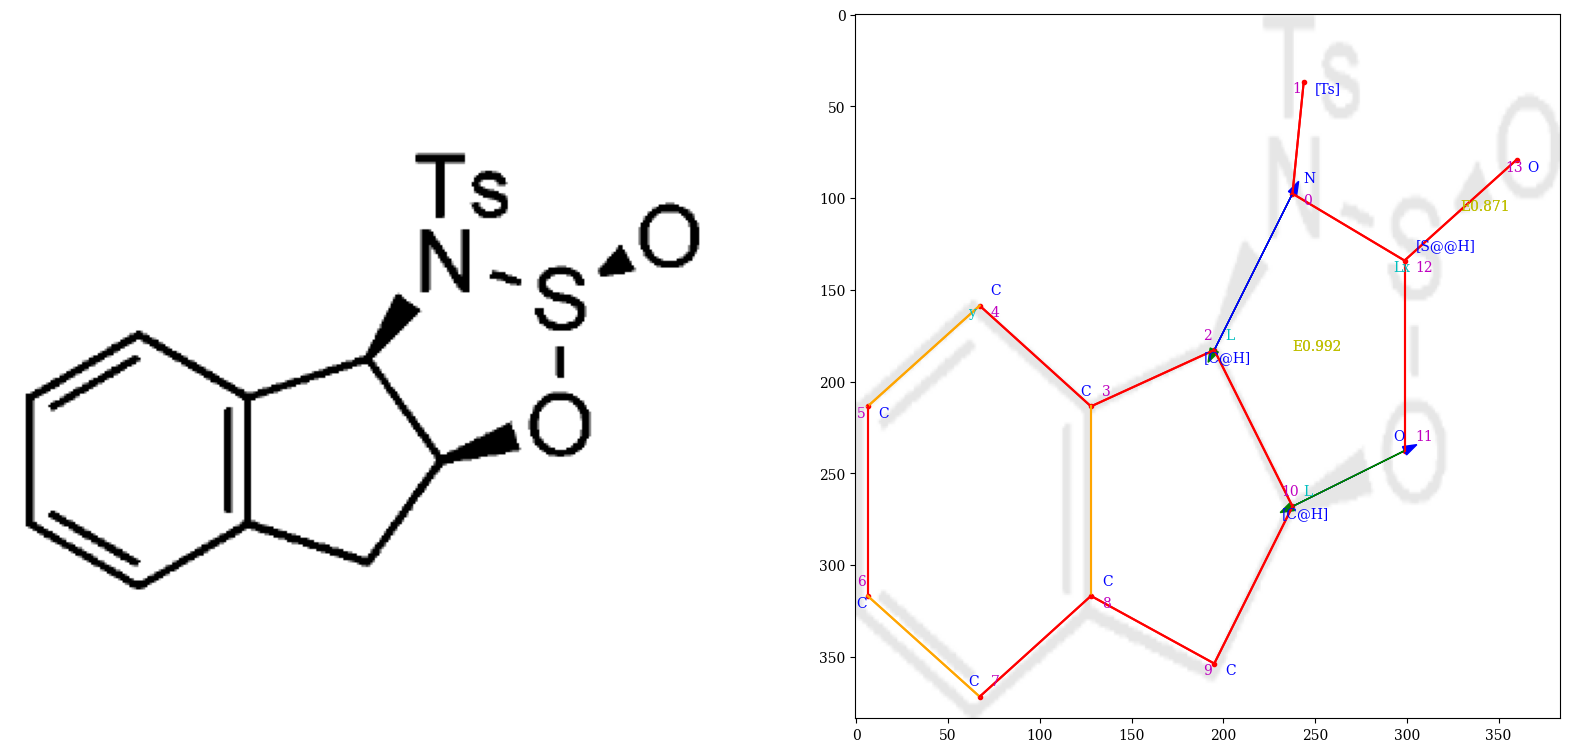

In [170]:
verbose = False
find_bad_atom = False

# OLD
#img_ind = [[49, 46], [], [3, 16], [], [33], [], [8]]
#img_ind = [[], [], [], [], [], [], []]
#img_ind = None
#img_ind = [[14, 21], [], [], [0], [], [7, 8], []]
# img_ind = [[116], [22, 26, 36]] # atoms
# img_ind = [[72, 203, 407], [90]] # bonds alt
# img_ind = [[72, 407], []] # bonds
# img_ind = None

# NEW (chartok)
# img_ind = [[673, 738, 1731, 2646, 2806], [4, 17, 29, 113, 114, 126, 127, 128, 194, 240]] # atoms (chartok)
# img_ind = [[1731, 2646, 2806], [4, 29, 114, 127, 128]] # atoms (chartok)
# img_ind = [[1731], [17, 128, 240]] # atoms (chartok)
# img_ind = [[1731], [113, 128, 298]]
# img_ind = [[116, 203, 407], [210, 256]] # bonds (chartok)
img_ind = [[116, 407], [210, 256]] # bonds (chartok)
# img_ind = None

chartok = True

def normalize_nodes(nodes):
    return nodes
    # x, y = nodes[:, 0], nodes[:, 1]
    # minx, maxx = min(x), max(x)
    # miny, maxy = min(y), max(y)
    # x = (x - minx) / max(maxx - minx, 1e-6)
    # y = (maxy - y) / max(maxy - miny, 1e-6)
    # return np.stack([x, y], axis=1)

def get_nodes(smiles):
    indigo = Indigo()
    renderer = IndigoRenderer(indigo)
    indigo.setOption('render-output-format', 'png')
    indigo.setOption('render-background-color', '1,1,1')
    indigo.setOption('render-stereo-style', 'none')
    indigo.setOption('render-label-mode', 'hetero')
    mol = indigo.loadMolecule(smiles)
    img = renderer.renderToBuffer(mol)
    mol.layout()
    nodes = []
    for atom in mol.iterateAtoms():
        x, y = atom.coords()
        nodes.append([x, y])
    nodes = np.array(nodes)
    return nodes


for set_idx, (df_path, extra_img_path, nodes_pred_df_path) in enumerate(zip(df_paths, extra_img_paths, nodes_pred_df_paths)):
    df = pd.read_csv(gold_root + df_path)
    nodes_pred_df = pd.read_csv(pred_root + nodes_pred_df_path)
    print('DATA:', df_path)
    print('PRED:', nodes_pred_df_path)
    count = 0
    shown_df = df if img_ind is None else df.iloc[img_ind[set_idx]]
    for i, row in shown_df.iterrows():
        # if count == 20:
        #     break
        assert row['image_id'] == nodes_pred_df.loc[i, 'image_id']
        smiles = row['SMILES']
        gold_smiles, canon_success = canonicalize_smiles(smiles)
        pred_smiles = nodes_pred_df.loc[i, 'SMILES']
        post_smiles = nodes_pred_df.loc[i, 'post_SMILES']
        smiles_token_scores = eval(nodes_pred_df.loc[i, 'SMILES_token_scores'])
        edges_token_scores = eval(nodes_pred_df.loc[i, 'edges_token_scores'])
        # if np.all(np.array(edges_token_scores) > 0.985):
        #     continue
        indices = eval(nodes_pred_df.loc[i, 'indices'])
        # if gold_smiles == post_smiles or type(post_smiles) is not str:
        #     continue
        if gold_smiles.replace('/', '').replace('\\', '') == post_smiles.replace('/', '').replace('\\', ''):
            continue
        if img_ind is not None and img_ind is None and canonicalize_smiles(gold_smiles, True) == canonicalize_smiles(post_smiles, True):
            continue
        count += 1
        # if count <= 200:
        #     continue
        print(f'## {i} ##')
        print('Image ID:', row['image_id'])
    #     print('Orig:', smiles)
        print('Gold:', gold_smiles)
        print('Pred:', pred_smiles)
        print('Post:', post_smiles)
        # print('Last SMILES scores:', smiles_token_scores[indices[-1]:])
        print('Indices:', indices)
        # print('SMILES scores:', smiles_token_scores)
        # print('Edges scores:', edges_token_scores)
        # print(len(pred_smiles), len(smiles_token_scores), type(smiles_token_scores))
        if '<unk>' in pred_smiles:
            print("WARNING: unknown token. Ignoring and continuing")
            continue

        # GET ALL TOKENS
        smiles_tokens = atomwise_tokenizer(pred_smiles)
        print(indices)
        print(smiles_tokens)
        coords = np.array(eval(nodes_pred_df.loc[i, 'node_coords']))
        all_tokens, atom_indices, idx2atom_idx = [], [], []
        atom_idx = 0
        cur_idx = 0
        for token in smiles_tokens:
            all_tokens.append(token)
            if isinstance(token, float) or token not in NON_ATOM_SYMB:
                idx2atom_idx.append(atom_idx)
            else:
                idx2atom_idx.append('')
            if token not in NON_ATOM_SYMB:
                atom_indices.append(cur_idx)
                all_tokens.append(coords[atom_idx][0])
                all_tokens.append(coords[atom_idx][1])
                idx2atom_idx.extend([atom_idx, atom_idx])
                atom_idx += 1
                cur_idx += 3
            else:
                cur_idx += 1
        assert atom_idx == len(coords) == len(indices) == len(atom_indices)
        # assert all(id == at_id + 3 for id, at_id in zip(indices, atom_indices))
        all_tokens.append('<eos>')
        idx2atom_idx.append('')
        if chartok:
            new_smiles_token_scores = []  # merge separate characters of token into one
            j = 0
            for token in all_tokens:
                if isinstance(token, float) or len(token) == 1 or token == '<eos>':
                    new_smiles_token_scores.append(smiles_token_scores[j])
                    j += 1
                else:
                    length = len(token)
                    avg_score = np.prod(smiles_token_scores[j:j+length])
                    new_smiles_token_scores.append(avg_score)
                    j += length
            assert j == len(smiles_token_scores)
            smiles_token_scores = new_smiles_token_scores
        assert len(all_tokens) == len(smiles_token_scores) == len(idx2atom_idx)
        bad_tokens = defaultdict(str)
        exists_bad = False
        for idx, (atom_idx, token) in enumerate(zip(idx2atom_idx, all_tokens)):
            token_score = smiles_token_scores[idx]
            # if token_score < 0.8:
            if token_score < 0.7:
                if atom_idx == '' or idx == 0 or idx2atom_idx[idx-1] != atom_idx:
                    bad = 'L'
                else:
                    bad = 'x' if idx == 1 or idx2atom_idx[idx-2] != atom_idx else 'y'
                if verbose or idx == len(idx2atom_idx) - 1:
                    print(f"{idx}\t{atom_idx}\t{token}\t{token_score}\t{bad}")
                if atom_idx != '':
                    if bad and bad[0] == 'L':
                        exists_bad = True
                    bad_tokens[atom_idx] += bad
            else:
                if verbose:
                    print(f"{idx}\t{atom_idx}\t{token}\t{token_score}")
        
        if find_bad_atom and not exists_bad:
            continue

        # PLOT ORIGINAL
        path = extra_img_path + row['file_path']
        img = cv2.imread(path)
        print(img.shape)
    #     nodes = get_nodes(smiles)
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.axis('off')
    #     plt.scatter(nodes[:,0], nodes[:,1])
        plt.subplot(1,2,2)
        transform = A.Compose([CropWhite(pad=0), A.Resize(384,384)])
        img = transform(image=img)['image']
        plt.imshow(img, alpha=0.1)

        # PLOT ATOMS
        h, w, _ = img.shape
        delta = 6
        DIR = [(delta, -delta), (delta, delta), (-delta, delta), (-delta, -delta)]
        symbols = np.array(eval(nodes_pred_df.loc[i, 'node_symbols']))
        x, y = coords[:,0]*w, coords[:,1]*h
        plt.scatter(x, y, color='r', marker='.')
        for idx, (xi, yi, symb) in enumerate(zip(x, y, symbols)):
            if idx < 1000:
                plt.annotate(symb, (xi+DIR[idx%4][0], yi+DIR[idx%4][1]), color='blue')
                plt.annotate(idx, (xi+DIR[(idx+1)%4][0], yi+DIR[(idx+1)%4][1]), color='m')
                if bad_tokens[idx]:
                    plt.annotate(bad_tokens[idx], (xi+DIR[(idx+2)%4][0], yi+DIR[(idx+2)%4][1]), color='c')

        # PLOT BONDS
        edges = eval(nodes_pred_df.loc[i, 'edges'])
        post_smiles, mol, *_ = _postprocess_smiles(pred_smiles, coords, symbols, edges, debug=True)
        for i in range(len(x)):
            for j in range(len(x)):
                if edges_token_scores[i][j] < 0.995:
                    plt.annotate('E{:.3f}'.format(edges_token_scores[i][j]), ((x[i]+x[j])/2, (y[i]+y[j])/2), color='y')
                    if verbose and i <= j:
                        print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}\tE')
                elif verbose and edges[i][j] != 0 and i <= j:
                    print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}')
                if edges[i][j] != 0:
                    if edges[i][j] in [5, 6]:
                        color = 'blue' if edges[i][j] == 5 else 'green'
                        plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], color=color, head_width=5)
    #                     print(i, j, edges[i][j], edges[j][i])
                    else:
                        if edges[i][j] == 1:
                            color = 'red'
                        elif edges[i][j] == 2:
                            color = 'orange'
                        else:
                            color = 'yellow'
                        plt.plot([x[i], x[j]], [y[i], y[j]], color)
        plt.show()
        
        # canon_gold = canonicalize_smiles(gold_smiles, True)[0]
        # canon_pred = canonicalize_smiles(pred_smiles, True)[0]
        # mol = Chem.MolFromSmiles(pred_smiles)
        # chiral_centers = Chem.FindMolChiralCenters(
        #         mol, includeUnassigned=True, includeCIP=False, useLegacyImplementation=False)
        # print(chiral_centers)
        # mol0 = Chem.MolFromSmiles(canon_gold, sanitize=False)
        # mol = Chem.MolFromSmiles(canon_pred, sanitize=False)
        # try:
        #     img = Chem.Draw.MolsToGridImage([mol0,mol], subImgSize=(250,250), molsPerRow=2, useSVG=True)
        #     display(img)
        # except:
        #     pass

DATA: Img2Mol/UOB.csv
PRED: uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv
## 1731 ##
Gold: OB(O)c1cc2ccccc2s1
Pred: [B-](O)(O)C1SC2C=CC=CC=2C=1
Post: O[B-](O)c1cc2ccccc2s1
Indices: [6, 10, 15, 19, 23, 26, 30, 34, 37, 41, 44, 49]
[6, 10, 15, 19, 23, 26, 30, 34, 37, 41, 44, 49]
['[B-]', '(', 'O', ')', '(', 'O', ')', 'C', '1', 'S', 'C', '2', 'C', '=', 'C', 'C', '=', 'C', 'C', '=', '2', 'C', '=', '1']
(303, 550, 3)
[0, 4, 9, 13, 17, 20, 24, 28, 31, 35, 38, 43]
DATA: acs/acs-331.csv
PRED: uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv
## 113 ##
Gold: Cc1sc(C)c(P(c2ccccc2)c2ccccc2)c1-c1c(C)sc(C)c1P(c1ccccc1)c1ccccc1
Pred: CC1SC(C)=C(C2C([Ph2])=C(C)SC=2C)C=1[Ph2]
Post: *c1c(C)sc(C)c1-c1c(C)sc(C)c1*
Indices: [3, 6, 10, 13, 17, 22, 26, 30, 38, 43, 47, 51, 54, 59, 63, 72]
[3, 6, 10, 13, 17, 22, 26, 30, 38, 43, 47, 51, 54, 59, 63, 72]
['C', 'C', '1', 'S', 'C', '(', 'C', ')', '=', 'C', '(', 'C', '2', 'C', '(', '[Ph2]', ')', '=', 'C', '(', 'C', ')', 'S', 'C', '=', '2', 'C

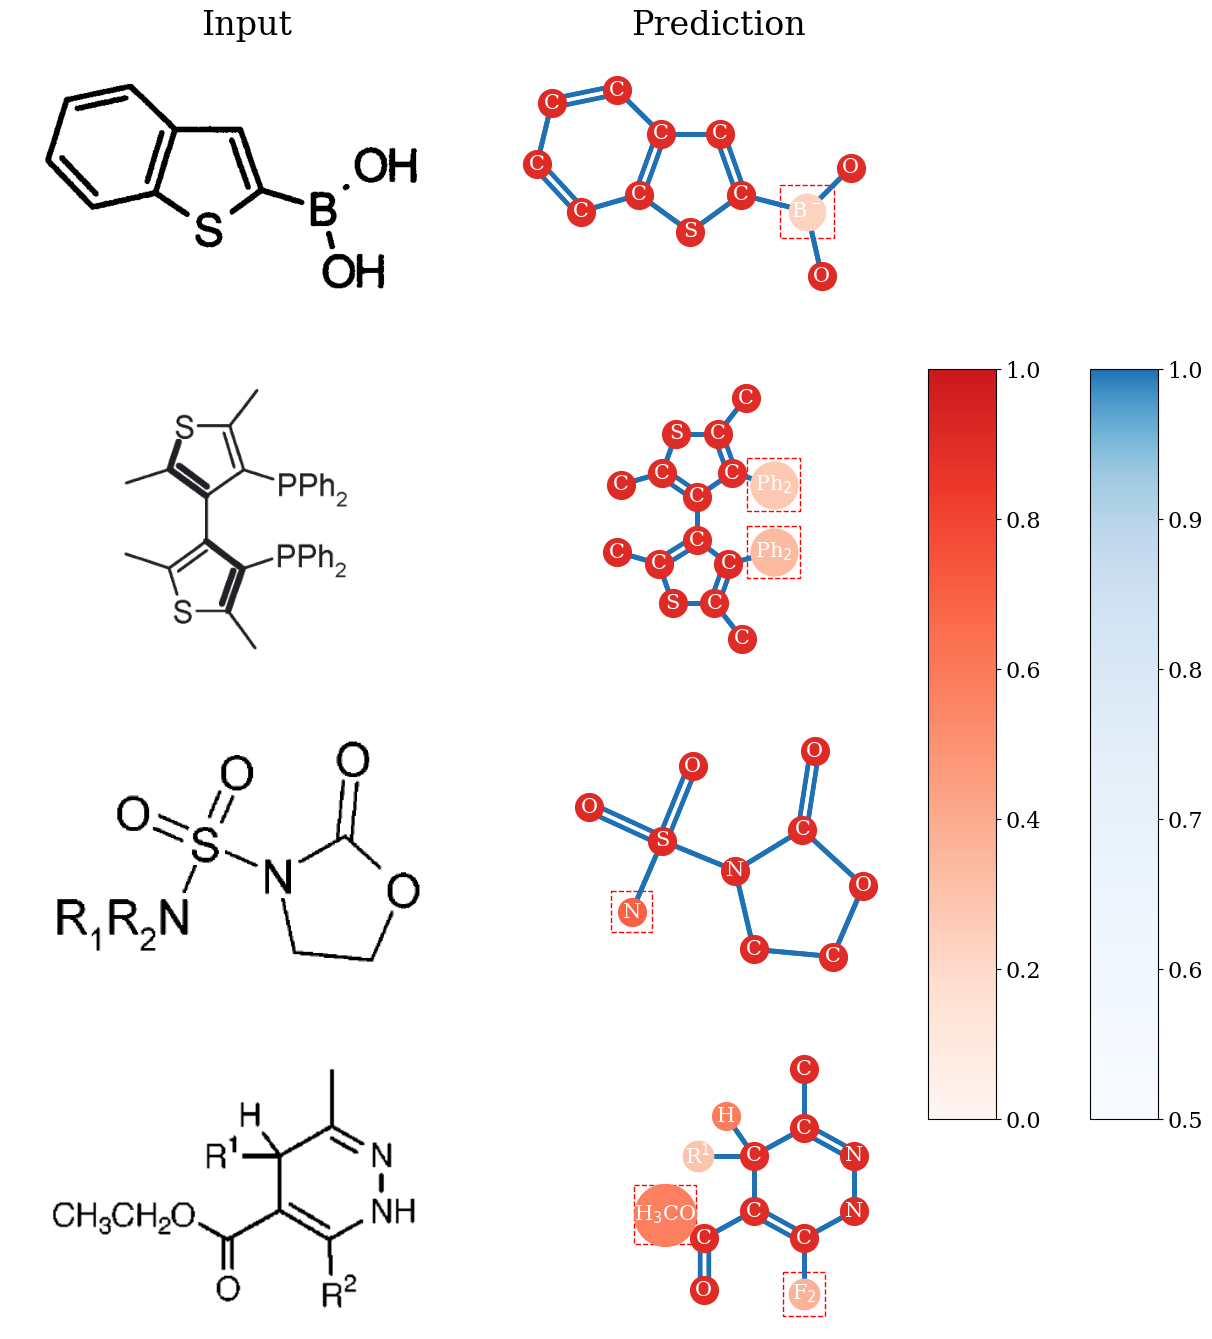

In [232]:
from matplotlib import patches
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib import cm

'''
def lighten_color(color, amount=0.5): # https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])
'''

def lighten_color(color, amount=0.5):
    return colormap(amount)

def bond_lighten_color(color, amount=0.5):
    return colormap_bond(amount)

def bond_conf_transform(conf, param=0.2):
    # scales conf to exaggerate differences
    return (param * (1 + param)) / (1 + param - conf) - param
    # return conf * 2 - 1

def atom_conf_transform(conf, param=0.5):
    # scales conf to exaggerate differences
    # return (param * (1 + param)) / (1 + param - conf) - param
    return conf

atom_colors = 'Reds'
bond_colors = 'Blues'
colormap = LinearSegmentedColormap.from_list("atom_cmap", cm.get_cmap(atom_colors)(0.75 * atom_conf_transform(np.arange(0., 1.0005, .001))))
colormap_bond = LinearSegmentedColormap.from_list("edge_cmap", cm.get_cmap(bond_colors)(0.75 * bond_conf_transform(np.arange(0., 1.0005, .001))))

def label_transform(token):
    token = token.strip('[]')
    at_pos = token.find('@')
    if at_pos != -1:
        token = token[:at_pos]
    eff_num_char = len(token)
    for i in range(10):
        eff_num_char -= 0.6 * token.count(str(i))
        token = token.replace(str(i), '$_{}$'.format(i))
        token = token.replace('R$_{}$'.format(i), 'R$^{}$'.format(i))
    eff_num_char -= 0.25 * (token.count('+') + token.count('-'))
    token = token.replace('+', '$^+$').replace('-', '$^-$')
    return token, eff_num_char

def draw_bond(x1, y1, x2, y2, bond_type, amt=1, diff_colors=False):
    if diff_colors:
        amt = bond_conf_transform(amt)
        if bond_type in [5, 6]:
            color = '#1F77B4' if edges[i][j] == 5 else '#2CA02C'
            color = lighten_color(color, amount=amt)
            ax2.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(color=color, width=5, shrink=0.15), zorder=2)
    #                     print(i, j, edges[i][j], edges[j][i])
        else:
            if bond_type == 1:
                color = '#FF7F0E'
            elif bond_type == 2:
                color = '#9467BD'
            else:
                color = '#E377C2'
            color = lighten_color(color, amount=amt)
            ax2.plot([x1, x2], [y1, y2], color=color, linewidth=5)
    else:
        # color = '#FF7F0E'
        color = '#9467BD'
        color = bond_lighten_color(color, amount=amt)
        if bond_type == 1:
            ax2.plot([x1, x2], [y1, y2], color=color, linewidth=3.5)
        elif bond_type == 2:
            ax2.plot([x1, x2], [y1, y2], color=color, linewidth=9.5)
            ax2.plot([x1, x2], [y1, y2], color='w', linewidth=2.5, zorder=2.1)
        elif bond_type == 3:
            x1s, x2s = 0.8*x1 + 0.2*x2, 0.2*x1 + 0.8*x2
            y1s, y2s = 0.8*y1 + 0.2*y2, 0.2*y1 + 0.8*y2
            ax2.plot([x1s, x2s], [y1s, y2s], color=color, linewidth=15.5)
            ax2.plot([x1, x2], [y1, y2], color='w', linewidth=8.5, zorder=2.05)
            ax2.plot([x1, x2], [y1, y2], color=color, linewidth=3.5, zorder=2.1)
        elif bond_type in [5, 6]:
            pixels = ax2.transData.transform([(x1, y1), (x2, y2)])
            points = 0.8 * pixels  # default dpi is 100
            length = np.linalg.norm(points[0] - points[1]).item()
            width = 10
            x1, y1 = 0.95*x1 + 0.05*x2, 0.95*y1 + 0.05*y2
            if bond_type == 5:
                ax2.annotate('', xy=(x1, y1), xytext=(x2, y2), arrowprops=dict(color=color, headwidth=width, headlength=length), zorder=2)
            else:
                dl = 8
                ddl = 3
                for i, temp_l in enumerate(reversed(np.arange(dl, length, dl))):
                    for temp_color, temp_w_scale in [(color, 1.), ('w', 1.2)]:
                        t = temp_l / length
                        x3, y3 = (1-t)*x1 + t*x2, (1-t)*y1 + t*y2
                        temp_w = t * width
                        print(temp_w, temp_l)
                        ax2.annotate('', xy=(x1, y1), xytext=(x3, y3), arrowprops=dict(color=temp_color, headwidth=temp_w*temp_w_scale, headlength=temp_l), zorder=2+i*.001)
                        temp_l -= ddl
        # elif bond_type == 6:
        #     # ax2.annotate('', xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(color=color, width=5, shrink=0.05, headlength=length), zorder=2)
        #     ax2.add_patch(patches.Wedge((x1, y1), np.sqrt((x1-x2)**2+(y1-y2)**2), 0, 45, linestyle='--'))
        else:
            # CHANGE IF EXISTS
            ax2.plot([x1, x2], [y1, y2], color='b', linewidth=5)
    
    

configs = [
    {
        'mode': 'atoms',
        'df_path': 'Img2Mol/UOB.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv',
        'idx': 1731,
        'xlim': (-10, 140),
        'ylim': (90, -15),
        'scale': (80, 180),
        'crop': A.Crop(x_max=550, y_min=40, y_max=343),
        'bad_idx': [0],
        'bad_box_dim': [(21, 20)],
        'save_fig': 'atom_uncertain_1.pdf'
    },
    # {
    #     'mode': 'atoms',
    #     'df_path': 'acs/acs-331.csv',
    #     'extra_img_path': '../',
    #     'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
    #     'idx': 17,
    #     'xlim': (-5, 150),
    #     'ylim': (100, -30),
    #     'scale': (65, 140),
    #     'crop': lambda image: {'image': image},
    #     'bad_idx': [6, 7],
    #     'bad_box_dim': [(16, 18), (20, 22.5)],
    #     'save_fig': 'atom_uncertain_2.pdf'
    # },
    {
        'mode': 'atoms',
        'df_path': 'acs/acs-331.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
        'idx': 113,
        'xlim': (-80, 200),
        'ylim': (85, -5),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': [8, 15],
        'bad_box_dim': [(39, 17), (39, 17)],
        'save_fig': 'atom_uncertain_5.pdf'
    },
    {
        'mode': 'atoms',
        'df_path': 'acs/acs-331.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
        'idx': 128,
        'xlim': (0, 160),
        'ylim': (90, -5),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': [3],
        'bad_box_dim': [(17, 14)],
        'save_fig': 'atom_uncertain_3.pdf'
    },
    # {
    #     'mode': 'atoms',
    #     'df_path': 'acs/acs-331.csv',
    #     'extra_img_path': '../',
    #     'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
    #     'idx': 240,
    #     'xlim': (-50, 150),
    #     'ylim': (82, -2),
    #     'scale': (80, 160),
    #     'crop': lambda image: {'image': image},
    #     'bad_idx': [1, 3],
    #     'bad_box_dim': [(22, 12), (22, 12)],
    #     'save_fig': 'atom_uncertain_4.pdf'
    # },
    {
        'mode': 'atoms',
        'df_path': 'acs/acs-331.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
        'idx': 298,
        'xlim': (-15, 160),
        'ylim': (85, -5),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': [7, 10],
        'bad_box_dim': [(28, 19), (19, 14)],
        'save_fig': 'atom_uncertain_6.pdf'
    },
    {
        'mode': 'bonds',
        'df_path': 'Img2Mol/UOB.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv',
        'idx': 407,
        'xlim': (-5, 180),
        'ylim': (85, -7),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': (9, 10),
        'label_rel_pos': (6, 2),
        'ha': 'left',
        'va': 'top',
        'no_draw': [(8, 7), (3, 4)],
        'save_fig': 'bond_uncertain_2.pdf'
    },
    {
        'mode': 'bonds',
        'df_path': 'acs/acs-331.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
        'idx': 210,
        'xlim': (-5, 165),
        'ylim': (95, -15),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': (2, 10),
        'label_rel_pos': (4, -3),
        'ha': 'left',
        'va': 'bottom',
        'no_draw': [(10, 2)],
        'save_fig': 'bond_uncertain_1.pdf'
    },
    {
        'mode': 'bonds',
        'df_path': 'acs/acs-331.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_acs-331.csv',
        'idx': 256,
        'xlim': (-5, 160),
        'ylim': (85, -10),
        'scale': (80, 160),
        'crop': lambda image: {'image': image},
        'bad_idx': (12, 13),
        'label_rel_pos': (6, 2),
        'ha': 'left',
        'va': 'top',
        'no_draw': [(0, 2), (11, 10)],
        'save_fig': 'bond_uncertain_4.pdf'
    },
    {
        'mode': 'bonds',
        'df_path': 'Img2Mol/UOB.csv',
        'extra_img_path': '../',
        'nodes_pred_df_path': 'uspto/swin_base_aux_200k_char_aug_b256/prediction_UOB.csv',
        'idx': 116,
        'xlim': (-10, 150),
        'ylim': (80, -10),
        'scale': (80, 160),
        'crop': A.Crop(x_max=600, y_max=389),
        'bad_idx': (2, 12),
        'label_rel_pos': (6, 2),
        'ha': 'left',
        'va': 'top',
        'no_draw': [(9, 7)],
        'save_fig': 'bond_uncertain_3.pdf'
    }
]

verbose = False
lighten_both = True
only_legend = False
no_legend = False
axis_off = True
atom_marker_size = 400
atom_font_size = 15

indices = None
subplot_h = 3.75
mode = 'atoms'
final_save_fig = "figures/uncertain_atoms_new.pdf"
configs = [config for config in configs if config['mode'] == mode]
configs = [config for idx, config in enumerate(configs) if indices is None or idx in indices]
fig, axes = plt.subplots(len(configs), 2)
if len(configs) == 1:
    axes = (axes,)
title_frac = 0.5/(subplot_h*len(configs)+0.25)
fig.subplots_adjust(right=0.75, top=1-title_frac)
fig.set_size_inches(3.6*subplot_h, subplot_h*len(configs))

tax1, tax2 = plt.axes([0.1, 1-title_frac, 0.35, 0.]), plt.axes([0.45, 1-title_frac, 0.35, 0.])
if axis_off:
    tax1.axis('off')
    tax2.axis('off')
tax1.set_title("Input", fontsize=24)
tax2.set_title("Prediction", fontsize=24)

if not no_legend:
    cax1, cax2 = plt.axes([0.78, 0.25, 0.05, 0.5]), plt.axes([0.9, 0.25, 0.05, 0.5])
    fig.colorbar(cm.ScalarMappable(Normalize(0., 1.), colormap), cax=cax1).ax.tick_params(labelsize=16)
    fig.colorbar(cm.ScalarMappable(Normalize(0.5, 1.), colormap_bond), cax=cax2).ax.tick_params(labelsize=16)

plt.rc('font', family="serif")
# axes = [ax for ax in ax_list for ax_list in axes]

for set_idx, (config, (ax1, ax2)) in enumerate(zip(configs, axes)):
    if only_legend:
        for axs in axes:
            for ax in axs:
                ax.axis('off')
        break
    # if set_idx == 0:
    #     ax1.set_title("Input", fontsize=24)
    #     ax2.set_title("Prediction", fontsize=24)
    mode, df_path, extra_img_path, nodes_pred_df_path = config['mode'], config['df_path'], config['extra_img_path'], config['nodes_pred_df_path']
    i, xlim, ylim, scale, transform = config['idx'], config['xlim'], config['ylim'], config['scale'], config['crop']
    bad_idx, bad_box_dim, label_rel_pos, ha, va, no_draw, save_fig = config['bad_idx'], config.get('bad_box_dim'), config.get('label_rel_pos'), config.get('ha'), config.get('va'), config.get('no_draw', []), config['save_fig']
    
    df = pd.read_csv(gold_root + df_path)
    nodes_pred_df = pd.read_csv(pred_root + nodes_pred_df_path)
    print('DATA:', df_path)
    print('PRED:', nodes_pred_df_path)
    row = df.iloc[i]
    
    assert row['image_id'] == nodes_pred_df.loc[i, 'image_id']
    smiles = row['SMILES']
    gold_smiles, canon_success = canonicalize_smiles(smiles)
    pred_smiles = nodes_pred_df.loc[i, 'SMILES']
    post_smiles = nodes_pred_df.loc[i, 'post_SMILES']
    smiles_token_scores = eval(nodes_pred_df.loc[i, 'SMILES_token_scores'])
    edges_token_scores = eval(nodes_pred_df.loc[i, 'edges_token_scores'])
    indices = eval(nodes_pred_df.loc[i, 'indices'])
    print(f'## {i} ##')
#     print('Orig:', smiles)
    print('Gold:', gold_smiles)
    print('Pred:', pred_smiles)
    print('Post:', post_smiles)
    # print('Last SMILES scores:', smiles_token_scores[indices[-1]:])
    print('Indices:', indices)
    # print('SMILES scores:', smiles_token_scores)
    # print('Edges scores:', edges_token_scores)
    # print(len(pred_smiles), len(smiles_token_scores), type(smiles_token_scores))
    if '<unk>' in pred_smiles:
        print("WARNING: unknown token. Ignoring and continuing")
        continue

    # GET ALL TOKENS
    smiles_tokens = atomwise_tokenizer(pred_smiles)
    print(indices)
    print(smiles_tokens)
    coords = np.array(eval(nodes_pred_df.loc[i, 'node_coords']))
    all_tokens, atom_indices, idx2atom_idx = [], [], []
    atom_idx = 0
    cur_idx = 0
    for token in smiles_tokens:
        all_tokens.append(token)
        if isinstance(token, float) or token not in NON_ATOM_SYMB:
            idx2atom_idx.append(atom_idx)
        else:
            idx2atom_idx.append('')
        if token not in NON_ATOM_SYMB:
            atom_indices.append(cur_idx)
            all_tokens.append(coords[atom_idx][0])
            all_tokens.append(coords[atom_idx][1])
            idx2atom_idx.extend([atom_idx, atom_idx])
            atom_idx += 1
            cur_idx += 3
        else:
            cur_idx += 1
    assert atom_idx == len(coords) == len(indices) == len(atom_indices)
    # assert all(id == at_id + 3 for id, at_id in zip(indices, atom_indices))
    all_tokens.append('<eos>')
    idx2atom_idx.append('')
    new_smiles_token_scores = []  # merge separate characters of token into one
    j = 0
    for token in all_tokens:
        if isinstance(token, float) or len(token) == 1 or token == '<eos>':
            new_smiles_token_scores.append(smiles_token_scores[j])
            j += 1
        else:
            length = len(token)
            avg_score = np.prod(smiles_token_scores[j:j+length])
            new_smiles_token_scores.append(avg_score)
            j += length
    assert j == len(smiles_token_scores)
    smiles_token_scores = new_smiles_token_scores
    assert len(all_tokens) == len(smiles_token_scores) == len(idx2atom_idx)
    bad_tokens = defaultdict(str)
    for idx, (atom_idx, token) in enumerate(zip(idx2atom_idx, all_tokens)):
        token_score = smiles_token_scores[idx]
        if token_score < 0.8:
            bad = 'L' if atom_idx == '' or idx == 0 or idx2atom_idx[idx-1] != atom_idx \
                                    else ('x' if idx == 1 or idx2atom_idx[idx-2] != atom_idx else 'y')
            if verbose or idx == len(idx2atom_idx) - 1:
                print(f"{idx}\t{atom_idx}\t{token}\t{token_score}\t{bad}")
            if atom_idx != '':
                bad_tokens[atom_idx] += bad
        else:
            if verbose:
                print(f"{idx}\t{atom_idx}\t{token}\t{token_score}")

    # PLOT ORIGINAL
    path = extra_img_path + row['file_path']
    img = transform(image=cv2.imread(path))['image']
    print(img.shape)
#     nodes = get_nodes(smiles)
    # plt.figure(figsize=(20,10))
    ax1.imshow(img)
    if axis_off:
        ax1.axis('off')

    # PLOTTING
    xlim = xlim if xlim else [-.1*img.shape[1], 1.1*img.shape[1]]
    ylim = ylim if ylim else [1.1*img.shape[0], -.1*img.shape[0]]
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    symbols = np.array(eval(nodes_pred_df.loc[i, 'node_symbols']))
    h, w = scale if scale else img.shape[:2]
    x, y = coords[:,0]*w, coords[:,1]*h
    # PLOT EDGES
    edges = eval(nodes_pred_df.loc[i, 'edges'])
    post_smiles, mol, *_ = _postprocess_smiles(pred_smiles, coords, symbols, edges, debug=True)
    for i in range(len(x)):
        for j in range(len(x)):
            # if edges_token_scores[i][j] < 0.995:
            if mode == 'bonds' and (i, j) == bad_idx:
                center = ((x[i]+x[j])/2, (y[i]+y[j])/2)
                length = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
                width = max(8, 0.3*length)
                angle = np.arctan2(y[i]-y[j], x[i]-x[j])
                print('angle', angle)
                # ax2.annotate('{:.3f}'.format(edges_token_scores[i][j]), (center[0]+label_rel_pos[0], center[1]+label_rel_pos[1]), color='r', ha=ha, va=va)
                ax2.add_patch(patches.Ellipse(center, 0.8*length, width, linewidth=1, edgecolor='r', facecolor='none', linestyle='dashed', angle=np.degrees(angle), zorder=2.6))
                if verbose and i <= j:
                    print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}\tE')
            elif verbose and edges[i][j] != 0 and i <= j:
                print(f'EDGE\t{i}\t{j}\t{edges_token_scores[i][j]}')
            if edges[i][j] != 0 and (i, j) not in no_draw:
                amt = edges_token_scores[i][j] if mode == 'bonds' or lighten_both else 1.0
                draw_bond(x[i], y[i], x[j], y[j], edges[i][j], amt)
    # PLOT ATOMS
    print(atom_indices)
    for idx, (xi, yi, symb) in enumerate(zip(x, y, symbols)):
        # ax2.add_patch(plt.Circle((xi, yi), radius=5, facecolor='#D62728', edgecolor='none', zorder=2.5))
        new_symb, eff_num_char = label_transform(symb)
        markersize = atom_marker_size * max(1, 0.8*eff_num_char) ** 1.6
        if mode == 'atoms' or lighten_both:
            conf_color = lighten_color('#D62728', amount=smiles_token_scores[atom_indices[idx]])
        else:
            conf_color = '#D62728'
        ax2.scatter([xi], [yi], color=conf_color, marker='o', s=markersize, zorder=2.5)
        ax2.annotate(new_symb, xy=(xi, yi), fontsize=atom_font_size, ha="center", va="center", color="white")
        # if bad_tokens[idx] == 'L':
        if mode == 'atoms' and idx in bad_idx:
            dx, dy = bad_box_dim[bad_idx.index(idx)]
            ax2.add_patch(plt.Rectangle((xi-dx/2, yi-dy/2), dx, dy, linewidth=1, edgecolor='r', facecolor='none', linestyle='dashed'))
            # ax2.annotate('{:.3f}'.format(smiles_token_scores[atom_indices[idx]]), xy=(xi, yi+.6*dy), color='r', ha="center", va="top")
    if axis_off:
        ax2.axis('off')
            
if final_save_fig:
    plt.savefig(final_save_fig)
fig.show()
#     mol = Chem.MolFromSmiles(pred_smiles)
#     chiral_centers = Chem.FindMolChiralCenters(
#             mol, includeUnassigned=True, includeCIP=False, useLegacyImplementation=False)
#     print(chiral_centers)
#     mol0 = Chem.MolFromSmiles(canon_gold, sanitize=False)
#     mol = Chem.MolFromSmiles(canon_pred, sanitize=False)
#     try:
#         img = Chem.Draw.MolsToGridImage([mol0,mol], subImgSize=(250,250), molsPerRow=2, useSVG=True)
#         display(img)
#     except:
#         pass